____

In [2]:
#importing all libraries
!pip install visualkeras      # <----------- Important!!! Install library in colab, if necessary
!pip install yfinance
!pip install pandas
!pip install matplotlib
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 16.4 MB/s eta 0:00:00


In [5]:
# Start Google Drive...
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/Colab Notebooks/SML/article/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1.3. Data preparation

First of all, let's load the dataset from file...
In order to better organize the data, some preliminary transformation were carried out:

* The time informatoin was better organized (timestamp)
* Time related rows were removed
* Number (_No_) row was removed


[*********************100%%**********************]  1 of 1 completed


                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-06-30  17.360001  17.549999  17.040001  17.290001   5.707791  20962900
2014-07-01  17.350000  17.450001  16.920000  17.190001   5.674780  22945200
2014-07-02  17.190001  17.330000  16.969999  17.120001   5.651670  28670600
2014-07-03  16.900000  17.530001  16.850000  17.520000   5.783720  26634700
2014-07-04  17.430000  17.549999  17.350000  17.500000   5.777117   9431900
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2024-06-24  36.840000  37.060001  36.480000  37.060001  37.060001  24599400
2024-06-25  37.049999  37.119999  36.759998  37.029999  37.029999  18572600
2024-06-26  36.799999  37.119999  36.709999  37.090000  37.090000  25553200
2024-06-27  37.509998  37.959999  37.320000  37.709999  37.709999  37731000
2024-06-28  

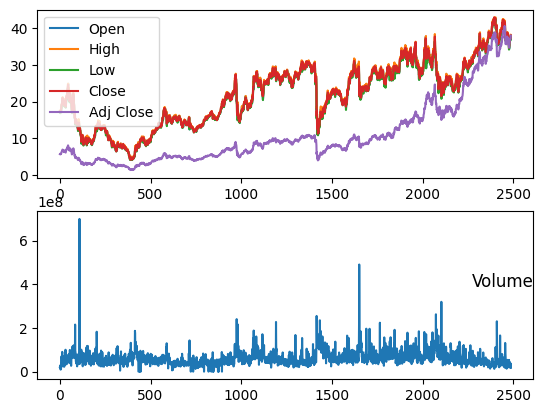

In [6]:
# Load dataset...

import yfinance as yf
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from datetime import datetime
import random
import numpy as np
import tensorflow as tf

# Defining the RNG
random.seed(22)
np.random.seed(42)
tf.random.set_seed(42)

dataset = yf.download('PETR4.SA', period='10y')
# print(dataset)

# Plot data...
value = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(2, 1, 1)
 pyplot.plot(value[:, group])
#  pyplot.title(dataset.columns[group], y=0.5, loc='right')
 pyplot.legend(dataset.columns[groups], loc='upper left')
 i += 1

pyplot.subplot(2, 1, 2)
pyplot.plot(value[:, 5])
pyplot.title(dataset.columns[5], y=0.5, loc='right')

print(dataset.head(5))
print(dataset.tail(5))
pyplot.show()


## 1.4. LSTM Data Preparation

In order to prepare the data to be presented to the LSTM, some aditional transformation were carried out:

* _NaNs_ were removed (replaced by 0)
* All features were normalized
<!--
After the transformation, all 6 **input variables refers to time "t-1"**, while the **output variable (pollution) refers to time "t"**. -->

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Preprocess data
# Select the 'Close' price
print(dataset.shape)
data = dataset[['Close']]

# Convert the data to a numpy array
dataset2 = data.values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset2)

# Define training data length
years_training = int(np.ceil(250*(2)))  # how many years before the test will be used?
month_test = int(np.ceil(21*(2)))  # how many months before yesterday will be udes for test
# training_data_len = int(np.ceil(len(scaled_data) * 0.8))

# Create the training data set
train_data = scaled_data[-(years_training + month_test):-month_test, :]
print(scaled_data.shape)
print(train_data.shape)
print(scaled_data[-(month_test)-5:-(month_test)])
print(train_data[-5:])

(2488, 6)
(2488, 1)
(500, 1)
[[0.96175702]
 [0.9568475 ]
 [0.98242893]
 [0.96770026]
 [0.98062016]]
[[0.96175702]
 [0.9568475 ]
 [0.98242893]
 [0.96770026]
 [0.98062016]]


In [8]:
# # Split the data into x_train and y_train data sets

def create_dataset(data, time_step=1):
    X, Y = [], []
    print(len(data))
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        # print(a)
        X.append(a)
        Y.append(data[i + time_step, 0])
        # print(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# number of previus values used to predict the next value
time_step = 1*21 # 21 days per month
X_train, y_train = create_dataset(train_data, time_step)
print(X_train.shape)
print(y_train.shape)
print(X_train[-1:])
print(y_train[-1:])

# Reshape the input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

500
(479, 21)
(479,)
[[0.85684753 0.86434109 0.88940562 0.88423764 0.87286817 0.87596892
  0.88966408 0.89224802 0.91447025 0.90697669 0.89767435 0.90723514
  0.91188631 0.91937978 0.92118856 0.93875962 0.96382425 0.96175702
  0.9568475  0.98242893 0.96770026]]
[0.98062016]


In [9]:
def create_dataset(data, years_tng, month_tst, time_step=1):
    X_train, X_test, y_train, y_test = [], [], [], []
    years_training = int(years_tng)  # how many years before the test will be used?
    month_test = int(month_tst)  # how many months before yesterday will be udes for test
    print(len(data))
    # scaled_data[-(years_training + month_test):-month_test, :]
    for i in range(years_training):
      tng = data[i-(years_training + month_test + time_step):(i)-(years_training + month_test), 0]
      X_train.append(tng)
      y_train.append(data[i - (years_training + month_test), 0])

    for i in range(month_tst):
      tst = data[i-(month_test + time_step):(i)-(month_test), 0]
      # print(i)
      # print(tst.shape)
      X_test.append(tst)
      y_test.append(data[i - (month_test), 0])

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# train_data = scaled_data[-(years_training + month_test):-month_test, :]
# number of previus values used to predict the next value
time_step = 1*21 # 21 days per month
X_train, y_train, X_test, y_test = create_dataset(scaled_data, years_training, month_test, time_step)
print(X_train.shape)
print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)
print(X_train[-1:])
print(y_train[-1:])

# Reshape the input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

2488
(500, 21)
(500,)
[[0.85684753 0.86434109 0.88940562 0.88423764 0.87286817 0.87596892
  0.88966408 0.89224802 0.91447025 0.90697669 0.89767435 0.90723514
  0.91188631 0.91937978 0.92118856 0.93875962 0.96382425 0.96175702
  0.9568475  0.98242893 0.96770026]]
[0.98062016]


Available Physical GPUs: 0
Epoch 1/1000
7/7 [==============================] - ETA: 0s - loss: 0.1908
Epoch 1: val_loss improved from inf to 0.02861, saving model to best_model.h5
7/7 [==============================] - 13s 389ms/step - loss: 0.1908 - val_loss: 0.0286


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/1000
7/7 [==============================] - ETA: 0s - loss: 0.0289
Epoch 2: val_loss did not improve from 0.02861
7/7 [==============================] - 2s 321ms/step - loss: 0.0289 - val_loss: 0.0537
Epoch 3/1000
7/7 [==============================] - ETA: 0s - loss: 0.0214
Epoch 3: val_loss improved from 0.02861 to 0.02296, saving model to best_model.h5
7/7 [==============================] - 1s 82ms/step - loss: 0.0214 - val_loss: 0.0230
Epoch 4/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.0098

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0119
Epoch 4: val_loss improved from 0.02296 to 0.00698, saving model to best_model.h5
7/7 [==============================] - 4s 719ms/step - loss: 0.0119 - val_loss: 0.0070
Epoch 5/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0104
Epoch 5: val_loss did not improve from 0.00698
7/7 [==============================] - 3s 443ms/step - loss: 0.0104 - val_loss: 0.0289
Epoch 6/1000
7/7 [==============================] - ETA: 0s - loss: 0.0111
Epoch 6: val_loss did not improve from 0.00698
7/7 [==============================] - 1s 42ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 7/1000
7/7 [==============================] - ETA: 0s - loss: 0.0095
Epoch 7: val_loss did not improve from 0.00698
7/7 [==============================] - 0s 52ms/step - loss: 0.0095 - val_loss: 0.0158
Epoch 8/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0087
Epoch 8: val_loss did not improve from 0.00698
7/7 [==============================] - 1s 86ms/step - loss: 0.0088 - val_loss: 0.0165
Epoch 9/1000
7/7 [==============================] - ETA: 0s - loss: 0.0088
Epoch 9: val_loss did not improve from 0.00698
7/7 [==============================] - 0s 45ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 60ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 18/1000
7/7 [==============================] - ETA: 0s - loss: 0.0063
Epoch 18: val_loss did not improve from 0.00696
7/7 [==============================] - 3s 535ms/step - loss: 0.0063 - val_loss: 0.0136
Epoch 19/1000
7/7 [==============================] - ETA: 0s - loss: 0.0062
Epoch 19: val_loss improved from 0.00696 to 0.00463, saving model to best_model.h5
7/7 [==============================] - 0s 50ms/step - loss: 0.0062 - val_loss: 0.0046
Epoch 20/1000
3/7 [===========>..................] - ETA: 0s - loss: 0.0067

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0065
Epoch 20: val_loss did not improve from 0.00463
7/7 [==============================] - 0s 45ms/step - loss: 0.0065 - val_loss: 0.0060
Epoch 21/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0064
Epoch 21: val_loss did not improve from 0.00463
7/7 [==============================] - 1s 95ms/step - loss: 0.0065 - val_loss: 0.0101
Epoch 22/1000
7/7 [==============================] - ETA: 0s - loss: 0.0068
Epoch 22: val_loss did not improve from 0.00463
7/7 [==============================] - 0s 45ms/step - loss: 0.0068 - val_loss: 0.0091
Epoch 23/1000
7/7 [==============================] - ETA: 0s - loss: 0.0062
Epoch 23: val_loss did not improve from 0.00463
7/7 [==============================] - 1s 177ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 24/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0057
Epoch 24: val_loss did not improve from 0.00463
7/7 [==============================] - 1s 227ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0064
Epoch 27: val_loss did not improve from 0.00453
7/7 [==============================] - 3s 443ms/step - loss: 0.0064 - val_loss: 0.0098
Epoch 28/1000
7/7 [==============================] - ETA: 0s - loss: 0.0060
Epoch 28: val_loss did not improve from 0.00453
7/7 [==============================] - 1s 93ms/step - loss: 0.0060 - val_loss: 0.0072
Epoch 29/1000
7/7 [==============================] - ETA: 0s - loss: 0.0060
Epoch 29: val_loss improved from 0.00453 to 0.00342, saving model to best_model.h5
7/7 [==============================] - 0s 51ms/step - loss: 0.0060 - val_loss: 0.0034
Epoch 30/1000
3/7 [===========>..................] - ETA: 0s - loss: 0.0057

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0057
Epoch 30: val_loss did not improve from 0.00342
7/7 [==============================] - 1s 184ms/step - loss: 0.0057 - val_loss: 0.0042
Epoch 31/1000
7/7 [==============================] - ETA: 0s - loss: 0.0055
Epoch 31: val_loss did not improve from 0.00342
7/7 [==============================] - 2s 387ms/step - loss: 0.0055 - val_loss: 0.0062
Epoch 32/1000
7/7 [==============================] - ETA: 0s - loss: 0.0050
Epoch 32: val_loss did not improve from 0.00342
7/7 [==============================] - 0s 43ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 33/1000
7/7 [==============================] - ETA: 0s - loss: 0.0056
Epoch 33: val_loss did not improve from 0.00342
7/7 [==============================] - 0s 47ms/step - loss: 0.0056 - val_loss: 0.0065
Epoch 34/1000
7/7 [==============================] - ETA: 0s - loss: 0.0049
Epoch 34: val_loss did not improve from 0.00342
7/7 [==============================] - 1s 85ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0056
Epoch 38: val_loss did not improve from 0.00256
7/7 [==============================] - 1s 183ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 39/1000
7/7 [==============================] - ETA: 0s - loss: 0.0055
Epoch 39: val_loss did not improve from 0.00256
7/7 [==============================] - 1s 232ms/step - loss: 0.0055 - val_loss: 0.0074
Epoch 40/1000
7/7 [==============================] - ETA: 0s - loss: 0.0053
Epoch 40: val_loss did not improve from 0.00256
7/7 [==============================] - 0s 47ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 41/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0052
Epoch 41: val_loss did not improve from 0.00256
7/7 [==============================] - 1s 197ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 42/1000
7/7 [==============================] - ETA: 0s - loss: 0.0053
Epoch 42: val_loss did not improve from 0.00256
7/7 [==============================] - 2s 377ms

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0049
Epoch 52: val_loss did not improve from 0.00252
7/7 [==============================] - 0s 46ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 53/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0047
Epoch 53: val_loss did not improve from 0.00252
7/7 [==============================] - 0s 52ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 54/1000
7/7 [==============================] - ETA: 0s - loss: 0.0045
Epoch 54: val_loss did not improve from 0.00252
7/7 [==============================] - 2s 222ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 55/1000
7/7 [==============================] - ETA: 0s - loss: 0.0046
Epoch 55: val_loss did not improve from 0.00252
7/7 [==============================] - 0s 44ms/step - loss: 0.0046 - val_loss: 0.0026
Epoch 56/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0041
Epoch 56: val_loss did not improve from 0.00252
7/7 [==============================] - 0s 55ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0043
Epoch 60: val_loss did not improve from 0.00219
7/7 [==============================] - 0s 52ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 61/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0043
Epoch 61: val_loss did not improve from 0.00219
7/7 [==============================] - 2s 319ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 62/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0041
Epoch 62: val_loss improved from 0.00219 to 0.00219, saving model to best_model.h5
7/7 [==============================] - 1s 101ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 63/1000
3/7 [===========>..................] - ETA: 0s - loss: 0.0050

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0047
Epoch 63: val_loss did not improve from 0.00219
7/7 [==============================] - 0s 47ms/step - loss: 0.0047 - val_loss: 0.0059
Epoch 64/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0039
Epoch 64: val_loss did not improve from 0.00219
7/7 [==============================] - 1s 180ms/step - loss: 0.0040 - val_loss: 0.0079
Epoch 65/1000
7/7 [==============================] - ETA: 0s - loss: 0.0040
Epoch 65: val_loss did not improve from 0.00219
7/7 [==============================] - 1s 221ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 66/1000
7/7 [==============================] - ETA: 0s - loss: 0.0044
Epoch 66: val_loss did not improve from 0.00219
7/7 [==============================] - 0s 45ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 67/1000
7/7 [==============================] - ETA: 0s - loss: 0.0042
Epoch 67: val_loss improved from 0.00219 to 0.00204, saving model to best_model.h5
7/7 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0038
Epoch 68: val_loss did not improve from 0.00204
7/7 [==============================] - 2s 302ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 69/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0049
Epoch 69: val_loss did not improve from 0.00204
7/7 [==============================] - 1s 109ms/step - loss: 0.0048 - val_loss: 0.0076
Epoch 70/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0040
Epoch 70: val_loss did not improve from 0.00204
7/7 [==============================] - 1s 76ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 71/1000
7/7 [==============================] - ETA: 0s - loss: 0.0041
Epoch 71: val_loss did not improve from 0.00204
7/7 [==============================] - 3s 507ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 72/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0041
Epoch 72: val_loss did not improve from 0.00204
7/7 [==============================] - 0s 47ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0037
Epoch 78: val_loss did not improve from 0.00192
7/7 [==============================] - 1s 91ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 79/1000
7/7 [==============================] - ETA: 0s - loss: 0.0032
Epoch 79: val_loss did not improve from 0.00192
7/7 [==============================] - 0s 48ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 80/1000
7/7 [==============================] - ETA: 0s - loss: 0.0032
Epoch 80: val_loss did not improve from 0.00192
7/7 [==============================] - 1s 181ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 81/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0030
Epoch 81: val_loss did not improve from 0.00192
7/7 [==============================] - 3s 476ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 82/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0034
Epoch 82: val_loss did not improve from 0.00192
7/7 [==============================] - 1s 111ms/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0035
Epoch 86: val_loss did not improve from 0.00169
7/7 [==============================] - 0s 44ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 87/1000
7/7 [==============================] - ETA: 0s - loss: 0.0038
Epoch 87: val_loss did not improve from 0.00169
7/7 [==============================] - 0s 46ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 88/1000
7/7 [==============================] - ETA: 0s - loss: 0.0040
Epoch 88: val_loss did not improve from 0.00169
7/7 [==============================] - 2s 334ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 89/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0033
Epoch 89: val_loss did not improve from 0.00169
7/7 [==============================] - 1s 89ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 90/1000
7/7 [==============================] - ETA: 0s - loss: 0.0033
Epoch 90: val_loss did not improve from 0.00169
7/7 [==============================] - 0s 44ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0036
Epoch 95: val_loss did not improve from 0.00165
7/7 [==============================] - 2s 254ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 96/1000
7/7 [==============================] - ETA: 0s - loss: 0.0031
Epoch 96: val_loss improved from 0.00165 to 0.00156, saving model to best_model.h5
7/7 [==============================] - 1s 236ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 97/1000
1/7 [===>..........................] - ETA: 0s - loss: 0.0038

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0036
Epoch 97: val_loss improved from 0.00156 to 0.00156, saving model to best_model.h5
7/7 [==============================] - 2s 374ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 98/1000
3/7 [===========>..................] - ETA: 0s - loss: 0.0034

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0035
Epoch 98: val_loss did not improve from 0.00156
7/7 [==============================] - 0s 47ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 99/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0033
Epoch 99: val_loss did not improve from 0.00156
7/7 [==============================] - 1s 85ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 100/1000
7/7 [==============================] - ETA: 0s - loss: 0.0029
Epoch 100: val_loss did not improve from 0.00156
7/7 [==============================] - 0s 45ms/step - loss: 0.0029 - val_loss: 0.0075
Epoch 101/1000
7/7 [==============================] - ETA: 0s - loss: 0.0038
Epoch 101: val_loss did not improve from 0.00156
7/7 [==============================] - 0s 44ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 102/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0030
Epoch 102: val_loss did not improve from 0.00156
7/7 [==============================] - 1s 92

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0030
Epoch 105: val_loss did not improve from 0.00148
7/7 [==============================] - 2s 365ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 106/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0035
Epoch 106: val_loss did not improve from 0.00148
7/7 [==============================] - 0s 47ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 107/1000
7/7 [==============================] - ETA: 0s - loss: 0.0029
Epoch 107: val_loss did not improve from 0.00148
7/7 [==============================] - 0s 44ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 108/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0032
Epoch 108: val_loss did not improve from 0.00148
7/7 [==============================] - 1s 88ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 109/1000
7/7 [==============================] - ETA: 0s - loss: 0.0028
Epoch 109: val_loss did not improve from 0.00148
7/7 [==============================] - 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0027
Epoch 118: val_loss did not improve from 0.00147
7/7 [==============================] - 2s 321ms/step - loss: 0.0027 - val_loss: 0.0045
Epoch 119/1000
7/7 [==============================] - ETA: 0s - loss: 0.0028
Epoch 119: val_loss did not improve from 0.00147
7/7 [==============================] - 1s 229ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 120/1000
7/7 [==============================] - ETA: 0s - loss: 0.0027
Epoch 120: val_loss did not improve from 0.00147
7/7 [==============================] - 0s 47ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 121/1000
7/7 [==============================] - ETA: 0s - loss: 0.0025
Epoch 121: val_loss did not improve from 0.00147
7/7 [==============================] - 0s 49ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 122/1000
7/7 [==============================] - ETA: 0s - loss: 0.0026
Epoch 122: val_loss improved from 0.00147 to 0.00130, saving model to best_model.h5
7/7 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0027
Epoch 123: val_loss did not improve from 0.00130
7/7 [==============================] - 1s 73ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 124/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0026
Epoch 124: val_loss did not improve from 0.00130
7/7 [==============================] - 1s 110ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 125/1000
7/7 [==============================] - ETA: 0s - loss: 0.0026
Epoch 125: val_loss did not improve from 0.00130
7/7 [==============================] - 1s 81ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 126/1000
7/7 [==============================] - ETA: 0s - loss: 0.0023
Epoch 126: val_loss did not improve from 0.00130
7/7 [==============================] - 2s 313ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 127/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0026
Epoch 127: val_loss improved from 0.00130 to 0.00125, saving model to best_model.h5
7/7 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0025
Epoch 128: val_loss improved from 0.00125 to 0.00121, saving model to best_model.h5
7/7 [==============================] - 0s 53ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 129/1000
7/7 [==============================] - ETA: 0s - loss: 0.0028
Epoch 129: val_loss did not improve from 0.00121
7/7 [==============================] - 1s 193ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 130/1000
7/7 [==============================] - ETA: 0s - loss: 0.0033
Epoch 130: val_loss did not improve from 0.00121
7/7 [==============================] - 2s 368ms/step - loss: 0.0033 - val_loss: 0.0063
Epoch 131/1000
7/7 [==============================] - ETA: 0s - loss: 0.0032
Epoch 131: val_loss did not improve from 0.00121
7/7 [==============================] - 0s 45ms/step - loss: 0.0032 - val_loss: 0.0076
Epoch 132/1000
7/7 [==============================] - ETA: 0s - loss: 0.0033
Epoch 132: val_loss did not improve from 0.00121
7/7 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0030
Epoch 134: val_loss did not improve from 0.00111
7/7 [==============================] - 1s 97ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 135/1000
7/7 [==============================] - ETA: 0s - loss: 0.0029
Epoch 135: val_loss did not improve from 0.00111
7/7 [==============================] - 0s 44ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 136/1000
7/7 [==============================] - ETA: 0s - loss: 0.0026
Epoch 136: val_loss did not improve from 0.00111
7/7 [==============================] - 0s 44ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 137/1000
7/7 [==============================] - ETA: 0s - loss: 0.0025
Epoch 137: val_loss did not improve from 0.00111
7/7 [==============================] - 1s 190ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 138/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0025
Epoch 138: val_loss did not improve from 0.00111
7/7 [==============================] - 2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0023
Epoch 149: val_loss did not improve from 0.00099
7/7 [==============================] - 1s 96ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 150/1000
7/7 [==============================] - ETA: 0s - loss: 0.0020
Epoch 150: val_loss did not improve from 0.00099
7/7 [==============================] - 0s 45ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 151/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0022
Epoch 151: val_loss did not improve from 0.00099
7/7 [==============================] - 1s 178ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 152/1000
7/7 [==============================] - ETA: 0s - loss: 0.0024
Epoch 152: val_loss improved from 0.00099 to 0.00096, saving model to best_model.h5
7/7 [==============================] - 3s 550ms/step - loss: 0.0024 - val_loss: 9.6167e-04
Epoch 153/1000
2/7 [=======>......................] - ETA: 0s - loss: 0.0020

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0021
Epoch 153: val_loss did not improve from 0.00096
7/7 [==============================] - 0s 55ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 154/1000
7/7 [==============================] - ETA: 0s - loss: 0.0023
Epoch 154: val_loss did not improve from 0.00096
7/7 [==============================] - 1s 92ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 155/1000
7/7 [==============================] - ETA: 0s - loss: 0.0023
Epoch 155: val_loss did not improve from 0.00096
7/7 [==============================] - 0s 52ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 156/1000
7/7 [==============================] - ETA: 0s - loss: 0.0020
Epoch 156: val_loss did not improve from 0.00096
7/7 [==============================] - 0s 50ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 157/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0018
Epoch 157: val_loss did not improve from 0.00096
7/7 [==============================] - 2s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0021
Epoch 159: val_loss did not improve from 0.00088
7/7 [==============================] - 0s 47ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 160/1000
7/7 [==============================] - ETA: 0s - loss: 0.0020
Epoch 160: val_loss did not improve from 0.00088
7/7 [==============================] - 0s 48ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 161/1000
7/7 [==============================] - ETA: 0s - loss: 0.0023
Epoch 161: val_loss did not improve from 0.00088
7/7 [==============================] - 2s 298ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 162/1000
7/7 [==============================] - ETA: 0s - loss: 0.0018
Epoch 162: val_loss did not improve from 0.00088
7/7 [==============================] - 1s 221ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 163/1000
7/7 [==============================] - ETA: 0s - loss: 0.0019
Epoch 163: val_loss did not improve from 0.00088
7/7 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0018
Epoch 175: val_loss did not improve from 0.00082
7/7 [==============================] - 0s 49ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 176/1000
7/7 [==============================] - ETA: 0s - loss: 0.0020
Epoch 176: val_loss did not improve from 0.00082
7/7 [==============================] - 2s 362ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 177/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0019
Epoch 177: val_loss did not improve from 0.00082
7/7 [==============================] - 1s 76ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 178/1000
7/7 [==============================] - ETA: 0s - loss: 0.0017
Epoch 178: val_loss did not improve from 0.00082
7/7 [==============================] - 2s 352ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 179/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0019
Epoch 179: val_loss did not improve from 0.00082
7/7 [==============================] - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0018
Epoch 183: val_loss did not improve from 0.00079
7/7 [==============================] - 0s 46ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 184/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0016
Epoch 184: val_loss did not improve from 0.00079
7/7 [==============================] - 1s 89ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 185/1000
7/7 [==============================] - ETA: 0s - loss: 0.0016
Epoch 185: val_loss did not improve from 0.00079
7/7 [==============================] - 0s 44ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 186/1000
7/7 [==============================] - ETA: 0s - loss: 0.0016
Epoch 186: val_loss did not improve from 0.00079
7/7 [==============================] - 0s 50ms/step - loss: 0.0016 - val_loss: 8.4393e-04
Epoch 187/1000
7/7 [==============================] - ETA: 0s - loss: 0.0015
Epoch 187: val_loss did not improve from 0.00079
7/7 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0019
Epoch 200: val_loss did not improve from 0.00070
7/7 [==============================] - 0s 45ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 201/1000
7/7 [==============================] - ETA: 0s - loss: 0.0015
Epoch 201: val_loss did not improve from 0.00070
7/7 [==============================] - 0s 50ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 202/1000
7/7 [==============================] - ETA: 0s - loss: 0.0015
Epoch 202: val_loss did not improve from 0.00070
7/7 [==============================] - 2s 376ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 203/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0014
Epoch 203: val_loss did not improve from 0.00070
7/7 [==============================] - 1s 75ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 204/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0016
Epoch 204: val_loss did not improve from 0.00070
7/7 [==============================] - 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0015
Epoch 210: val_loss did not improve from 0.00070
7/7 [==============================] - 1s 226ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 211/1000
7/7 [==============================] - ETA: 0s - loss: 0.0014
Epoch 211: val_loss did not improve from 0.00070
7/7 [==============================] - 0s 50ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 212/1000
7/7 [==============================] - ETA: 0s - loss: 0.0016
Epoch 212: val_loss did not improve from 0.00070
7/7 [==============================] - 0s 44ms/step - loss: 0.0016 - val_loss: 8.8189e-04
Epoch 213/1000
7/7 [==============================] - ETA: 0s - loss: 0.0014
Epoch 213: val_loss improved from 0.00070 to 0.00066, saving model to best_model.h5
7/7 [==============================] - 1s 186ms/step - loss: 0.0014 - val_loss: 6.5745e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 214/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0014
Epoch 214: val_loss did not improve from 0.00066
7/7 [==============================] - 1s 231ms/step - loss: 0.0014 - val_loss: 9.3904e-04
Epoch 215/1000
7/7 [==============================] - ETA: 0s - loss: 0.0012
Epoch 215: val_loss did not improve from 0.00066
7/7 [==============================] - 0s 45ms/step - loss: 0.0012 - val_loss: 8.9621e-04
Epoch 216/1000
7/7 [==============================] - ETA: 0s - loss: 0.0014
Epoch 216: val_loss did not improve from 0.00066
7/7 [==============================] - 0s 47ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 217/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0015
Epoch 217: val_loss did not improve from 0.00066
7/7 [==============================] - 3s 481ms/step - loss: 0.0015 - val_loss: 6.7045e-04
Epoch 218/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0014
Epoch 218: val_loss did not improve from 0.00066
7/7 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0015
Epoch 221: val_loss did not improve from 0.00065
7/7 [==============================] - 2s 308ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 222/1000
7/7 [==============================] - ETA: 0s - loss: 0.0014
Epoch 222: val_loss did not improve from 0.00065
7/7 [==============================] - 1s 98ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 223/1000
7/7 [==============================] - ETA: 0s - loss: 0.0014
Epoch 223: val_loss did not improve from 0.00065
7/7 [==============================] - 0s 46ms/step - loss: 0.0014 - val_loss: 9.1535e-04
Epoch 224/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0014
Epoch 224: val_loss did not improve from 0.00065
7/7 [==============================] - 1s 186ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 225/1000
7/7 [==============================] - ETA: 0s - loss: 0.0013
Epoch 225: val_loss did not improve from 0.00065
7/7 [==============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0014
Epoch 238: val_loss did not improve from 0.00064
7/7 [==============================] - 2s 305ms/step - loss: 0.0014 - val_loss: 7.0970e-04
Epoch 239/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0013
Epoch 239: val_loss did not improve from 0.00064
7/7 [==============================] - 1s 94ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 240/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 240: val_loss did not improve from 0.00064
7/7 [==============================] - 0s 44ms/step - loss: 0.0011 - val_loss: 6.5827e-04
Epoch 241/1000
7/7 [==============================] - ETA: 0s - loss: 0.0013
Epoch 241: val_loss did not improve from 0.00064
7/7 [==============================] - 0s 53ms/step - loss: 0.0013 - val_loss: 6.9035e-04
Epoch 242/1000
7/7 [==============================] - ETA: 0s - loss: 0.0012
Epoch 242: val_loss did not improve from 0.00064
7/7 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0012
Epoch 256: val_loss did not improve from 0.00062
7/7 [==============================] - 2s 387ms/step - loss: 0.0012 - val_loss: 8.7859e-04
Epoch 257/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0011
Epoch 257: val_loss did not improve from 0.00062
7/7 [==============================] - 1s 80ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 258/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0011
Epoch 258: val_loss did not improve from 0.00062
7/7 [==============================] - 1s 122ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 259/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0012
Epoch 259: val_loss did not improve from 0.00062
7/7 [==============================] - 1s 130ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 260/1000
7/7 [==============================] - ETA: 0s - loss: 0.0012
Epoch 260: val_loss did not improve from 0.00062
7/7 [=============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 272: val_loss did not improve from 0.00061
7/7 [==============================] - 2s 360ms/step - loss: 0.0011 - val_loss: 6.9042e-04
Epoch 273/1000
6/7 [========================>.....] - ETA: 0s - loss: 0.0011
Epoch 273: val_loss improved from 0.00061 to 0.00059, saving model to best_model.h5
7/7 [==============================] - 1s 232ms/step - loss: 0.0011 - val_loss: 5.9297e-04
Epoch 274/1000
3/7 [===========>..................] - ETA: 0s - loss: 0.0010

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0010
Epoch 274: val_loss did not improve from 0.00059
7/7 [==============================] - 0s 47ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 275/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 275: val_loss did not improve from 0.00059
7/7 [==============================] - 1s 94ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 276/1000
7/7 [==============================] - ETA: 0s - loss: 0.0012
Epoch 276: val_loss did not improve from 0.00059
7/7 [==============================] - 0s 45ms/step - loss: 0.0012 - val_loss: 8.1053e-04
Epoch 277/1000
7/7 [==============================] - ETA: 0s - loss: 0.0013
Epoch 277: val_loss did not improve from 0.00059
7/7 [==============================] - 1s 89ms/step - loss: 0.0013 - val_loss: 7.0283e-04
Epoch 278/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 278: val_loss improved from 0.00059 to 0.00057, saving model to best_model.h

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 279: val_loss did not improve from 0.00057
7/7 [==============================] - 0s 47ms/step - loss: 0.0011 - val_loss: 9.7263e-04
Epoch 280/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 280: val_loss did not improve from 0.00057
7/7 [==============================] - 2s 379ms/step - loss: 0.0011 - val_loss: 8.5767e-04
Epoch 281/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 281: val_loss did not improve from 0.00057
7/7 [==============================] - 0s 44ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 282/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 282: val_loss did not improve from 0.00057
7/7 [==============================] - 0s 44ms/step - loss: 0.0011 - val_loss: 6.2306e-04
Epoch 283/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 283: val_loss did not improve from 0.00057
7/7 [=======================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0011
Epoch 300: val_loss improved from 0.00056 to 0.00055, saving model to best_model.h5
7/7 [==============================] - 2s 254ms/step - loss: 0.0010 - val_loss: 5.5224e-04
Epoch 301/1000
2/7 [=======>......................] - ETA: 0s - loss: 0.0012    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0010
Epoch 301: val_loss did not improve from 0.00055
7/7 [==============================] - 1s 75ms/step - loss: 0.0010 - val_loss: 5.6702e-04
Epoch 302/1000
7/7 [==============================] - ETA: 0s - loss: 9.6500e-04
Epoch 302: val_loss did not improve from 0.00055
7/7 [==============================] - 3s 452ms/step - loss: 9.6500e-04 - val_loss: 6.6696e-04
Epoch 303/1000
6/7 [========================>.....] - ETA: 0s - loss: 9.4030e-04
Epoch 303: val_loss did not improve from 0.00055
7/7 [==============================] - 1s 90ms/step - loss: 9.3011e-04 - val_loss: 7.1404e-04
Epoch 304/1000
7/7 [==============================] - ETA: 0s - loss: 0.0010
Epoch 304: val_loss did not improve from 0.00055
7/7 [==============================] - 0s 47ms/step - loss: 0.0010 - val_loss: 7.4798e-04
Epoch 305/1000
7/7 [==============================] - ETA: 0s - loss: 9.3720e-04
Epoch 305: val_loss did not improve from 0.00055
7/7 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 9.9150e-04
Epoch 314: val_loss improved from 0.00054 to 0.00053, saving model to best_model.h5
7/7 [==============================] - 2s 332ms/step - loss: 9.9150e-04 - val_loss: 5.3448e-04
Epoch 315/1000
3/7 [===========>..................] - ETA: 0s - loss: 0.0011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 0.0011
Epoch 315: val_loss did not improve from 0.00053
7/7 [==============================] - 1s 92ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 316/1000
7/7 [==============================] - ETA: 0s - loss: 9.9029e-04
Epoch 316: val_loss did not improve from 0.00053
7/7 [==============================] - 0s 44ms/step - loss: 9.9029e-04 - val_loss: 0.0011
Epoch 317/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 317: val_loss did not improve from 0.00053
7/7 [==============================] - 1s 187ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 318/1000
6/7 [========================>.....] - ETA: 0s - loss: 9.1730e-04
Epoch 318: val_loss did not improve from 0.00053
7/7 [==============================] - 1s 229ms/step - loss: 9.0130e-04 - val_loss: 6.8426e-04
Epoch 319/1000
7/7 [==============================] - ETA: 0s - loss: 9.2478e-04
Epoch 319: val_loss did not improve from 0.00053
7/7 [==========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 9.1260e-04
Epoch 322: val_loss did not improve from 0.00053
7/7 [==============================] - 0s 45ms/step - loss: 9.1260e-04 - val_loss: 8.9835e-04
Epoch 323/1000
7/7 [==============================] - ETA: 0s - loss: 0.0010    
Epoch 323: val_loss did not improve from 0.00053
7/7 [==============================] - 0s 54ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 324/1000
7/7 [==============================] - ETA: 0s - loss: 9.8787e-04
Epoch 324: val_loss did not improve from 0.00053
7/7 [==============================] - 2s 359ms/step - loss: 9.8787e-04 - val_loss: 7.1482e-04
Epoch 325/1000
6/7 [========================>.....] - ETA: 0s - loss: 8.7608e-04
Epoch 325: val_loss did not improve from 0.00053
7/7 [==============================] - 0s 72ms/step - loss: 8.9214e-04 - val_loss: 6.2318e-04
Epoch 326/1000
7/7 [==============================] - ETA: 0s - loss: 0.0010    
Epoch 326: val_loss did not improve from 0.00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 9.9121e-04
Epoch 338: val_loss did not improve from 0.00050
7/7 [==============================] - 2s 244ms/step - loss: 9.8173e-04 - val_loss: 5.3398e-04
Epoch 339/1000
7/7 [==============================] - ETA: 0s - loss: 9.2398e-04
Epoch 339: val_loss did not improve from 0.00050
7/7 [==============================] - 1s 77ms/step - loss: 9.2398e-04 - val_loss: 5.5148e-04
Epoch 340/1000
7/7 [==============================] - ETA: 0s - loss: 9.8614e-04
Epoch 340: val_loss did not improve from 0.00050
7/7 [==============================] - 3s 473ms/step - loss: 9.8614e-04 - val_loss: 7.1425e-04
Epoch 341/1000
7/7 [==============================] - ETA: 0s - loss: 8.7578e-04
Epoch 341: val_loss did not improve from 0.00050
7/7 [==============================] - 1s 96ms/step - loss: 8.7578e-04 - val_loss: 0.0010
Epoch 342/1000
6/7 [========================>.....] - ETA: 0s - loss: 9.0016e-04
Epoch 342: val_loss did not improve from

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 9.5506e-04
Epoch 346: val_loss did not improve from 0.00049
7/7 [==============================] - 1s 223ms/step - loss: 9.5506e-04 - val_loss: 5.7960e-04
Epoch 347/1000
7/7 [==============================] - ETA: 0s - loss: 0.0011
Epoch 347: val_loss did not improve from 0.00049
7/7 [==============================] - 0s 46ms/step - loss: 0.0011 - val_loss: 7.0735e-04
Epoch 348/1000
7/7 [==============================] - ETA: 0s - loss: 9.3237e-04
Epoch 348: val_loss did not improve from 0.00049
7/7 [==============================] - 1s 101ms/step - loss: 9.3237e-04 - val_loss: 0.0010
Epoch 349/1000
7/7 [==============================] - ETA: 0s - loss: 8.5923e-04
Epoch 349: val_loss did not improve from 0.00049
7/7 [==============================] - 0s 47ms/step - loss: 8.5923e-04 - val_loss: 0.0011
Epoch 350/1000
7/7 [==============================] - ETA: 0s - loss: 9.3390e-04
Epoch 350: val_loss did not improve from 0.00049
7/7

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 9.0178e-04
Epoch 357: val_loss did not improve from 0.00048
7/7 [==============================] - 1s 176ms/step - loss: 9.0178e-04 - val_loss: 5.6854e-04
Epoch 358/1000
7/7 [==============================] - ETA: 0s - loss: 8.4696e-04
Epoch 358: val_loss did not improve from 0.00048
7/7 [==============================] - 2s 369ms/step - loss: 8.4696e-04 - val_loss: 6.6589e-04
Epoch 359/1000
7/7 [==============================] - ETA: 0s - loss: 9.4265e-04
Epoch 359: val_loss did not improve from 0.00048
7/7 [==============================] - 0s 45ms/step - loss: 9.4265e-04 - val_loss: 4.8883e-04
Epoch 360/1000
7/7 [==============================] - ETA: 0s - loss: 8.9898e-04
Epoch 360: val_loss did not improve from 0.00048
7/7 [==============================] - 0s 45ms/step - loss: 8.9898e-04 - val_loss: 4.8375e-04
Epoch 361/1000
6/7 [========================>.....] - ETA: 0s - loss: 9.9040e-04
Epoch 361: val_loss did not improve 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 9.0440e-04
Epoch 375: val_loss did not improve from 0.00046
7/7 [==============================] - 0s 46ms/step - loss: 9.0440e-04 - val_loss: 4.7889e-04
Epoch 376/1000
6/7 [========================>.....] - ETA: 0s - loss: 8.8489e-04
Epoch 376: val_loss did not improve from 0.00046
7/7 [==============================] - 0s 53ms/step - loss: 8.6239e-04 - val_loss: 5.1359e-04
Epoch 377/1000
7/7 [==============================] - ETA: 0s - loss: 9.0549e-04
Epoch 377: val_loss improved from 0.00046 to 0.00045, saving model to best_model.h5
7/7 [==============================] - 2s 376ms/step - loss: 9.0549e-04 - val_loss: 4.5298e-04
Epoch 378/1000
2/7 [=======>......................] - ETA: 0s - loss: 8.8300e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 8.9673e-04
Epoch 378: val_loss did not improve from 0.00045
7/7 [==============================] - 1s 79ms/step - loss: 8.9673e-04 - val_loss: 0.0012
Epoch 379/1000
7/7 [==============================] - ETA: 0s - loss: 0.0010
Epoch 379: val_loss did not improve from 0.00045
7/7 [==============================] - 3s 478ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 380/1000
6/7 [========================>.....] - ETA: 0s - loss: 9.4081e-04
Epoch 380: val_loss did not improve from 0.00045
7/7 [==============================] - 1s 86ms/step - loss: 9.3443e-04 - val_loss: 8.4350e-04
Epoch 381/1000
7/7 [==============================] - ETA: 0s - loss: 7.7805e-04
Epoch 381: val_loss did not improve from 0.00045
7/7 [==============================] - 0s 45ms/step - loss: 7.7805e-04 - val_loss: 8.1348e-04
Epoch 382/1000
7/7 [==============================] - ETA: 0s - loss: 8.7578e-04
Epoch 382: val_loss did not improve from 0.00045
7/7 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 8.5028e-04
Epoch 395: val_loss did not improve from 0.00044
7/7 [==============================] - 0s 46ms/step - loss: 8.5028e-04 - val_loss: 6.4465e-04
Epoch 396/1000
6/7 [========================>.....] - ETA: 0s - loss: 8.0889e-04
Epoch 396: val_loss improved from 0.00044 to 0.00043, saving model to best_model.h5
7/7 [==============================] - 1s 110ms/step - loss: 7.8798e-04 - val_loss: 4.2627e-04
Epoch 397/1000
3/7 [===========>..................] - ETA: 0s - loss: 6.0617e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 7.7653e-04
Epoch 397: val_loss did not improve from 0.00043
7/7 [==============================] - 0s 46ms/step - loss: 7.7653e-04 - val_loss: 4.5982e-04
Epoch 398/1000
7/7 [==============================] - ETA: 0s - loss: 7.5991e-04
Epoch 398: val_loss did not improve from 0.00043
7/7 [==============================] - 1s 198ms/step - loss: 7.5991e-04 - val_loss: 9.6470e-04
Epoch 399/1000
7/7 [==============================] - ETA: 0s - loss: 8.0812e-04
Epoch 399: val_loss did not improve from 0.00043
7/7 [==============================] - 2s 362ms/step - loss: 8.0812e-04 - val_loss: 9.2620e-04
Epoch 400/1000
6/7 [========================>.....] - ETA: 0s - loss: 8.6389e-04
Epoch 400: val_loss did not improve from 0.00043
7/7 [==============================] - 0s 46ms/step - loss: 8.5324e-04 - val_loss: 8.8184e-04
Epoch 401/1000
7/7 [==============================] - ETA: 0s - loss: 8.1061e-04
Epoch 401: val_loss did not improve 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 61ms/step - loss: 8.2356e-04 - val_loss: 4.1832e-04
Epoch 407/1000
7/7 [==============================] - ETA: 0s - loss: 8.5239e-04
Epoch 407: val_loss did not improve from 0.00042
7/7 [==============================] - 2s 374ms/step - loss: 8.5239e-04 - val_loss: 4.5341e-04
Epoch 408/1000
7/7 [==============================] - ETA: 0s - loss: 8.1407e-04
Epoch 408: val_loss did not improve from 0.00042
7/7 [==============================] - 0s 47ms/step - loss: 8.1407e-04 - val_loss: 9.9344e-04
Epoch 409/1000
7/7 [==============================] - ETA: 0s - loss: 8.1135e-04
Epoch 409: val_loss did not improve from 0.00042
7/7 [==============================] - 0s 54ms/step - loss: 8.1135e-04 - val_loss: 5.6498e-04
Epoch 410/1000
7/7 [==============================] - ETA: 0s - loss: 7.1724e-04
Epoch 410: val_loss did not improve from 0.00042
7/7 [==============================] - 1s 208ms/step - loss: 7.1724e-04 - val_loss: 0.0011
Epoch 411/10

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 8.4102e-04
Epoch 413: val_loss did not improve from 0.00042
7/7 [==============================] - 2s 356ms/step - loss: 8.4102e-04 - val_loss: 4.5286e-04
Epoch 414/1000
7/7 [==============================] - ETA: 0s - loss: 8.7836e-04
Epoch 414: val_loss did not improve from 0.00042
7/7 [==============================] - 0s 43ms/step - loss: 8.7836e-04 - val_loss: 4.1932e-04
Epoch 415/1000
6/7 [========================>.....] - ETA: 0s - loss: 8.5392e-04
Epoch 415: val_loss did not improve from 0.00042
7/7 [==============================] - 1s 97ms/step - loss: 8.4871e-04 - val_loss: 4.2655e-04
Epoch 416/1000
7/7 [==============================] - ETA: 0s - loss: 8.2397e-04
Epoch 416: val_loss did not improve from 0.00042
7/7 [==============================] - 0s 46ms/step - loss: 8.2397e-04 - val_loss: 4.3999e-04
Epoch 417/1000
7/7 [==============================] - ETA: 0s - loss: 8.0475e-04
Epoch 417: val_loss improved from 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 7.4927e-04
Epoch 418: val_loss did not improve from 0.00041
7/7 [==============================] - 1s 232ms/step - loss: 7.8606e-04 - val_loss: 9.6903e-04
Epoch 419/1000
7/7 [==============================] - ETA: 0s - loss: 9.3125e-04
Epoch 419: val_loss did not improve from 0.00041
7/7 [==============================] - 0s 44ms/step - loss: 9.3125e-04 - val_loss: 0.0019
Epoch 420/1000
6/7 [========================>.....] - ETA: 0s - loss: 8.9056e-04
Epoch 420: val_loss did not improve from 0.00041
7/7 [==============================] - 0s 48ms/step - loss: 8.9409e-04 - val_loss: 0.0012
Epoch 421/1000
7/7 [==============================] - ETA: 0s - loss: 9.3628e-04
Epoch 421: val_loss did not improve from 0.00041
7/7 [==============================] - 1s 179ms/step - loss: 9.3628e-04 - val_loss: 5.4254e-04
Epoch 422/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.7360e-04
Epoch 422: val_loss did not improve from 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 8.1396e-04
Epoch 424: val_loss did not improve from 0.00040
7/7 [==============================] - 2s 370ms/step - loss: 8.1396e-04 - val_loss: 4.3522e-04
Epoch 425/1000
7/7 [==============================] - ETA: 0s - loss: 8.6106e-04
Epoch 425: val_loss did not improve from 0.00040
7/7 [==============================] - 0s 46ms/step - loss: 8.6106e-04 - val_loss: 0.0010
Epoch 426/1000
7/7 [==============================] - ETA: 0s - loss: 7.7336e-04
Epoch 426: val_loss did not improve from 0.00040
7/7 [==============================] - 0s 46ms/step - loss: 7.7336e-04 - val_loss: 0.0016
Epoch 427/1000
7/7 [==============================] - ETA: 0s - loss: 8.6051e-04
Epoch 427: val_loss did not improve from 0.00040
7/7 [==============================] - 1s 185ms/step - loss: 8.6051e-04 - val_loss: 7.5984e-04
Epoch 428/1000
7/7 [==============================] - ETA: 0s - loss: 8.3685e-04
Epoch 428: val_loss improved from 0.00040 to

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 7.2808e-04
Epoch 429: val_loss did not improve from 0.00040
7/7 [==============================] - 0s 46ms/step - loss: 7.2808e-04 - val_loss: 5.3378e-04
Epoch 430/1000
7/7 [==============================] - ETA: 0s - loss: 7.3931e-04
Epoch 430: val_loss improved from 0.00040 to 0.00040, saving model to best_model.h5
7/7 [==============================] - 1s 203ms/step - loss: 7.3931e-04 - val_loss: 3.9548e-04
Epoch 431/1000
1/7 [===>..........................] - ETA: 0s - loss: 5.3135e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 8.3772e-04
Epoch 431: val_loss did not improve from 0.00040
7/7 [==============================] - 1s 227ms/step - loss: 8.3772e-04 - val_loss: 4.3337e-04
Epoch 432/1000
7/7 [==============================] - ETA: 0s - loss: 7.1466e-04
Epoch 432: val_loss did not improve from 0.00040
7/7 [==============================] - 0s 43ms/step - loss: 7.1466e-04 - val_loss: 8.3318e-04
Epoch 433/1000
7/7 [==============================] - ETA: 0s - loss: 8.3913e-04
Epoch 433: val_loss did not improve from 0.00040
7/7 [==============================] - 1s 184ms/step - loss: 8.3913e-04 - val_loss: 5.5008e-04
Epoch 434/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.1288e-04
Epoch 434: val_loss did not improve from 0.00040
7/7 [==============================] - 1s 114ms/step - loss: 7.1076e-04 - val_loss: 4.4177e-04
Epoch 435/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.3072e-04
Epoch 435: val_loss did not improve

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 459/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.6348e-04
Epoch 459: val_loss did not improve from 0.00037
7/7 [==============================] - 1s 86ms/step - loss: 6.5671e-04 - val_loss: 6.4102e-04
Epoch 460/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.0134e-04
Epoch 460: val_loss did not improve from 0.00037
7/7 [==============================] - 0s 64ms/step - loss: 6.8332e-04 - val_loss: 8.4991e-04
Epoch 461/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.1650e-04
Epoch 461: val_loss did not improve from 0.00037
7/7 [==============================] - 2s 321ms/step - loss: 7.2019e-04 - val_loss: 3.7471e-04
Epoch 462/1000
6/7 [========================>.....] - ETA: 0s - loss: 8.0912e-04
Epoch 462: val_loss did not improve from 0.00037
7/7 [==============================] - 1s 121ms/step - loss: 7.9242e-04 - val_loss: 3.7700e-04
Epoch 463/1000
7/7 [==============================] - ETA: 0s - loss: 9.9301e-04
Epoch 463: val_loss i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 8.5207e-04
Epoch 464: val_loss did not improve from 0.00037
7/7 [==============================] - 2s 304ms/step - loss: 8.3542e-04 - val_loss: 3.9067e-04
Epoch 465/1000
7/7 [==============================] - ETA: 0s - loss: 7.7907e-04
Epoch 465: val_loss did not improve from 0.00037
7/7 [==============================] - 1s 227ms/step - loss: 7.7907e-04 - val_loss: 4.6286e-04
Epoch 466/1000
7/7 [==============================] - ETA: 0s - loss: 7.3925e-04
Epoch 466: val_loss did not improve from 0.00037
7/7 [==============================] - 0s 43ms/step - loss: 7.3925e-04 - val_loss: 0.0011
Epoch 467/1000
7/7 [==============================] - ETA: 0s - loss: 7.4460e-04
Epoch 467: val_loss did not improve from 0.00037
7/7 [==============================] - 0s 46ms/step - loss: 7.4460e-04 - val_loss: 4.1629e-04
Epoch 468/1000
7/7 [==============================] - ETA: 0s - loss: 6.6642e-04
Epoch 468: val_loss did not improve from

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 6.8609e-04
Epoch 494: val_loss did not improve from 0.00037
7/7 [==============================] - 1s 84ms/step - loss: 7.0865e-04 - val_loss: 4.6568e-04
Epoch 495/1000
7/7 [==============================] - ETA: 0s - loss: 7.0027e-04
Epoch 495: val_loss did not improve from 0.00037
7/7 [==============================] - 0s 48ms/step - loss: 7.0027e-04 - val_loss: 5.5062e-04
Epoch 496/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.6144e-04
Epoch 496: val_loss did not improve from 0.00037
7/7 [==============================] - 1s 97ms/step - loss: 7.0000e-04 - val_loss: 6.6584e-04
Epoch 497/1000
7/7 [==============================] - ETA: 0s - loss: 7.2790e-04
Epoch 497: val_loss did not improve from 0.00037
7/7 [==============================] - 0s 45ms/step - loss: 7.2790e-04 - val_loss: 4.5064e-04
Epoch 498/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.5905e-04
Epoch 498: val_loss did not improve fr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 6.8804e-04
Epoch 510: val_loss improved from 0.00036 to 0.00035, saving model to best_model.h5
7/7 [==============================] - 1s 95ms/step - loss: 6.8804e-04 - val_loss: 3.4802e-04
Epoch 511/1000
3/7 [===========>..................] - ETA: 0s - loss: 6.5186e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 6.5339e-04
Epoch 511: val_loss did not improve from 0.00035
7/7 [==============================] - 0s 44ms/step - loss: 6.5339e-04 - val_loss: 6.3634e-04
Epoch 512/1000
7/7 [==============================] - ETA: 0s - loss: 6.3731e-04
Epoch 512: val_loss did not improve from 0.00035
7/7 [==============================] - 0s 45ms/step - loss: 6.3731e-04 - val_loss: 7.5544e-04
Epoch 513/1000
7/7 [==============================] - ETA: 0s - loss: 7.3401e-04
Epoch 513: val_loss did not improve from 0.00035
7/7 [==============================] - 2s 321ms/step - loss: 7.3401e-04 - val_loss: 7.5474e-04
Epoch 514/1000
7/7 [==============================] - ETA: 0s - loss: 6.8616e-04
Epoch 514: val_loss did not improve from 0.00035
7/7 [==============================] - 1s 230ms/step - loss: 6.8616e-04 - val_loss: 4.1951e-04
Epoch 515/1000
7/7 [==============================] - ETA: 0s - loss: 6.8418e-04
Epoch 515: val_loss did not improve 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 7.7512e-04
Epoch 525: val_loss did not improve from 0.00034
7/7 [==============================] - 0s 45ms/step - loss: 7.7512e-04 - val_loss: 9.1035e-04
Epoch 526/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.7044e-04
Epoch 526: val_loss did not improve from 0.00034
7/7 [==============================] - 0s 56ms/step - loss: 6.6139e-04 - val_loss: 3.7562e-04
Epoch 527/1000
7/7 [==============================] - ETA: 0s - loss: 7.4506e-04
Epoch 527: val_loss did not improve from 0.00034
7/7 [==============================] - 3s 469ms/step - loss: 7.4506e-04 - val_loss: 3.5116e-04
Epoch 528/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.7740e-04
Epoch 528: val_loss did not improve from 0.00034
7/7 [==============================] - 1s 94ms/step - loss: 6.6992e-04 - val_loss: 3.8682e-04
Epoch 529/1000
7/7 [==============================] - ETA: 0s - loss: 7.2058e-04
Epoch 529: val_loss did not improve f

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 7.8774e-04
Epoch 543: val_loss did not improve from 0.00034
7/7 [==============================] - 0s 51ms/step - loss: 7.7003e-04 - val_loss: 3.9152e-04
Epoch 544/1000
6/7 [========================>.....] - ETA: 0s - loss: 8.8895e-04
Epoch 544: val_loss improved from 0.00034 to 0.00033, saving model to best_model.h5
7/7 [==============================] - 2s 358ms/step - loss: 8.7512e-04 - val_loss: 3.3144e-04
Epoch 545/1000
3/7 [===========>..................] - ETA: 0s - loss: 7.7736e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 7.1018e-04
Epoch 545: val_loss did not improve from 0.00033
7/7 [==============================] - 0s 48ms/step - loss: 7.1018e-04 - val_loss: 4.2656e-04
Epoch 546/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.1133e-04
Epoch 546: val_loss did not improve from 0.00033
7/7 [==============================] - 0s 71ms/step - loss: 6.0459e-04 - val_loss: 0.0012
Epoch 547/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.2482e-04
Epoch 547: val_loss did not improve from 0.00033
7/7 [==============================] - 3s 513ms/step - loss: 7.1648e-04 - val_loss: 7.3244e-04
Epoch 548/1000
7/7 [==============================] - ETA: 0s - loss: 6.8435e-04
Epoch 548: val_loss did not improve from 0.00033
7/7 [==============================] - 0s 46ms/step - loss: 6.8435e-04 - val_loss: 4.9636e-04
Epoch 549/1000
7/7 [==============================] - ETA: 0s - loss: 6.1340e-04
Epoch 549: val_loss did not improve from 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 6.4442e-04
Epoch 571: val_loss did not improve from 0.00032
7/7 [==============================] - 1s 90ms/step - loss: 6.4483e-04 - val_loss: 3.3081e-04
Epoch 572/1000
7/7 [==============================] - ETA: 0s - loss: 7.2165e-04
Epoch 572: val_loss did not improve from 0.00032
7/7 [==============================] - 0s 45ms/step - loss: 7.2165e-04 - val_loss: 4.3494e-04
Epoch 573/1000
7/7 [==============================] - ETA: 0s - loss: 6.7738e-04
Epoch 573: val_loss did not improve from 0.00032
7/7 [==============================] - 2s 342ms/step - loss: 6.7738e-04 - val_loss: 4.9106e-04
Epoch 574/1000
7/7 [==============================] - ETA: 0s - loss: 6.6242e-04
Epoch 574: val_loss did not improve from 0.00032
7/7 [==============================] - 2s 384ms/step - loss: 6.6242e-04 - val_loss: 6.7869e-04
Epoch 575/1000
7/7 [==============================] - ETA: 0s - loss: 6.4304e-04
Epoch 575: val_loss did not improve 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 7.3573e-04
Epoch 591: val_loss did not improve from 0.00032
7/7 [==============================] - 0s 45ms/step - loss: 7.3573e-04 - val_loss: 3.4608e-04
Epoch 592/1000
7/7 [==============================] - ETA: 0s - loss: 6.7688e-04
Epoch 592: val_loss did not improve from 0.00032
7/7 [==============================] - 2s 325ms/step - loss: 6.7688e-04 - val_loss: 3.5191e-04
Epoch 593/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.3287e-04
Epoch 593: val_loss did not improve from 0.00032
7/7 [==============================] - 1s 93ms/step - loss: 6.3593e-04 - val_loss: 7.1751e-04
Epoch 594/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.2253e-04
Epoch 594: val_loss did not improve from 0.00032
7/7 [==============================] - 0s 47ms/step - loss: 6.2987e-04 - val_loss: 3.7509e-04
Epoch 595/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.6626e-04
Epoch 595: val_loss did not improve f

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 6.5416e-04
Epoch 599: val_loss did not improve from 0.00032
7/7 [==============================] - 1s 76ms/step - loss: 6.5995e-04 - val_loss: 3.9020e-04
Epoch 600/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.4980e-04
Epoch 600: val_loss did not improve from 0.00032
7/7 [==============================] - 1s 187ms/step - loss: 6.4809e-04 - val_loss: 3.8307e-04
Epoch 601/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.2119e-04
Epoch 601: val_loss did not improve from 0.00032
7/7 [==============================] - 2s 358ms/step - loss: 7.2276e-04 - val_loss: 4.6048e-04
Epoch 602/1000
7/7 [==============================] - ETA: 0s - loss: 6.9853e-04
Epoch 602: val_loss did not improve from 0.00032
7/7 [==============================] - 0s 45ms/step - loss: 6.9853e-04 - val_loss: 0.0011
Epoch 603/1000
7/7 [==============================] - ETA: 0s - loss: 7.6965e-04
Epoch 603: val_loss did not improve from

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - ETA: 0s - loss: 6.9231e-04
Epoch 617: val_loss improved from 0.00031 to 0.00031, saving model to best_model.h5
7/7 [==============================] - 2s 333ms/step - loss: 6.9231e-04 - val_loss: 3.1087e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 618/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.1336e-04
Epoch 618: val_loss did not improve from 0.00031
7/7 [==============================] - 1s 96ms/step - loss: 7.1765e-04 - val_loss: 5.0860e-04
Epoch 619/1000
7/7 [==============================] - ETA: 0s - loss: 6.6428e-04
Epoch 619: val_loss did not improve from 0.00031
7/7 [==============================] - 0s 47ms/step - loss: 6.6428e-04 - val_loss: 0.0013
Epoch 620/1000
6/7 [========================>.....] - ETA: 0s - loss: 7.1167e-04
Epoch 620: val_loss did not improve from 0.00031
7/7 [==============================] - 1s 91ms/step - loss: 7.1563e-04 - val_loss: 6.2545e-04
Epoch 621/1000
7/7 [==============================] - ETA: 0s - loss: 6.5200e-04
Epoch 621: val_loss did not improve from 0.00031
7/7 [==============================] - 0s 46ms/step - loss: 6.5200e-04 - val_loss: 5.9899e-04
Epoch 622/1000
7/7 [==============================] - ETA: 0s - loss: 6.7025e-04
Epoch 622: val_loss did not

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 5.9670e-04
Epoch 640: val_loss did not improve from 0.00031
7/7 [==============================] - 1s 120ms/step - loss: 6.1078e-04 - val_loss: 5.7997e-04
Epoch 641/1000
7/7 [==============================] - ETA: 0s - loss: 6.7354e-04
Epoch 641: val_loss did not improve from 0.00031
7/7 [==============================] - 1s 100ms/step - loss: 6.7354e-04 - val_loss: 5.4037e-04
Epoch 642/1000
7/7 [==============================] - ETA: 0s - loss: 6.0791e-04
Epoch 642: val_loss did not improve from 0.00031
7/7 [==============================] - 0s 51ms/step - loss: 6.0791e-04 - val_loss: 5.1661e-04
Epoch 643/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.5311e-04
Epoch 643: val_loss did not improve from 0.00031
7/7 [==============================] - 1s 190ms/step - loss: 6.3933e-04 - val_loss: 3.3195e-04
Epoch 644/1000
7/7 [==============================] - ETA: 0s - loss: 6.0091e-04
Epoch 644: val_loss did not improve

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/7 [========================>.....] - ETA: 0s - loss: 5.9834e-04
Epoch 734: val_loss did not improve from 0.00031
7/7 [==============================] - 0s 49ms/step - loss: 5.8714e-04 - val_loss: 3.2484e-04
Epoch 735/1000
7/7 [==============================] - ETA: 0s - loss: 6.2252e-04
Epoch 735: val_loss improved from 0.00031 to 0.00031, saving model to best_model.h5
7/7 [==============================] - 1s 199ms/step - loss: 6.2252e-04 - val_loss: 3.0567e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 736/1000
7/7 [==============================] - ETA: 0s - loss: 6.8085e-04
Epoch 736: val_loss did not improve from 0.00031
7/7 [==============================] - 1s 233ms/step - loss: 6.8085e-04 - val_loss: 4.5915e-04
Epoch 737/1000
7/7 [==============================] - ETA: 0s - loss: 5.5962e-04
Epoch 737: val_loss did not improve from 0.00031
7/7 [==============================] - 0s 44ms/step - loss: 5.5962e-04 - val_loss: 3.1004e-04
Epoch 738/1000
6/7 [========================>.....] - ETA: 0s - loss: 6.3250e-04
Epoch 738: val_loss did not improve from 0.00031
7/7 [==============================] - 1s 85ms/step - loss: 6.6926e-04 - val_loss: 5.2391e-04
Epoch 739/1000
7/7 [==============================] - ETA: 0s - loss: 6.4444e-04
Epoch 739: val_loss did not improve from 0.00031
7/7 [==============================] - 0s 46ms/step - loss: 6.4444e-04 - val_loss: 6.0072e-04
Epoch 740/1000
7/7 [==============================] - ETA: 0s - loss: 6.2351e-04
Epoch 740: val_loss di

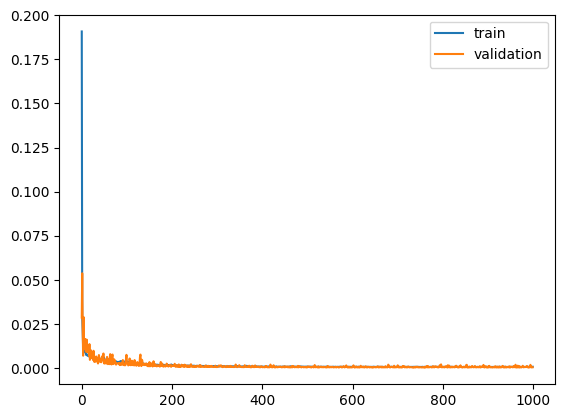

In [10]:
import os
import time
import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# List available physical GPUs
physical_devices = tf.config.list_physical_devices('GPU')
print("Available Physical GPUs:", len(physical_devices))

# If GPUs are available, configure GPU memory growth
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Build the model

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Callbacks for early stopping and saving the best model
early_stop = EarlyStopping(monitor='val_loss', patience=20) #val_loss
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss',verbose=1, save_best_only=True, mode='min')

# Train multiple models and compare the loss final value and curve
histories_loss = []
histories_val_loss = []
histories_training_time = []
best_models = []
# number of batch size to be used
# batch = [256, 128, 84, 64, 63, 42, 32, 21, 16, 8, 5, 4, 2, 1]
batch = [64]

for i in batch:
    # Measure training time
    start_time = time.time()
    model = build_model((X_train.shape[1], 1))
    history = model.fit(X_train, y_train, batch_size=i, epochs=1000, validation_split=0.2, callbacks=[model_checkpoint])
    end_time = time.time()
    training_time = end_time - start_time
    historie=[]
    histories_loss.append(history.history['loss'])
    histories_val_loss.append(history.history['val_loss'])
    histories_training_time.append(training_time)
    # Clear previous models and sessions
    if os.path.exists('best_model.h5'):
      best_model = load_model('best_model.h5')
      best_model.save(path + 'model_' + str(i))
      best_models.append(load_model('best_model.h5'))
      os.remove('best_model.h5')
      tf.keras.backend.clear_session()

# Save the DataFrame to a CSV file
histories_loss = pd.DataFrame(histories_loss)
histories_val_loss = pd.DataFrame(histories_val_loss)
histories_training_time = pd.DataFrame(histories_training_time)
histories_loss.to_csv(path + 'histories_loss.csv', index = False)
histories_val_loss.to_csv(path + 'histories_val_loss.csv', index = False)
histories_training_time.to_csv(path + 'histories_training_time.csv', index = False)

# Load the best model, use i to select te model
i = 64  #edit to select model to be used
if os.path.exists('best_model.h5'):
  best_model = load_model('best_model.h5')
else:
  best_model = load_model(path + 'model_' + str(i))

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [11]:
import matplotlib.pyplot as plt
# Plot the loss curves for comparison
plt.figure(figsize=(14, 8))

for i, histor in enumerate(history):
    plt.plot(histor.history['loss'], label=f"Model {i+1} (units={configurations[i]['units']}, epochs={configurations[i]['epochs']}, batch_size={configurations[i]['batch_size']})")

plt.title('Loss Curves for Different LSTM Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TypeError: 'History' object is not iterable

<Figure size 1400x800 with 0 Axes>

In [12]:
# Create the testing data set
test_data = scaled_data[-(month_test+time_step):, :]
# print(scaled_data.shape)
# print(test_data.shape)
# print(scaled_data[-5:])
# print(test_data[-5:])

# Create the data sets x_test and y_test
# X_test, y_test = create_dataset(test_data, time_step)
# print(X_test.shape)
# print(y_test.shape)

# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# print(X_test)
# print(X_test.shape)

# Get the model's predicted price values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
# print(predictions.shape)
# print(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - scaler.inverse_transform(y_test.reshape(-1, 1))) ** 2)))
print('RMSE:', rmse)

train = data[-(years_training + month_test):-month_test]
# print(train.shape)
valid = data[-month_test:-1]
# print(valid.shape)
# print(predictions.shape)
# valid = valid.iloc[:]  # Ensure the lengths match
valid['Predictions'] = predictions[1:]
# print(valid.shape)
# print(train[-50:])
# print(valid)

2/2 [==============================] - 5s 1s/step
RMSE: 0.7957883131523555


<ipython-input-12-dc27d3d5f77a>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[1:]


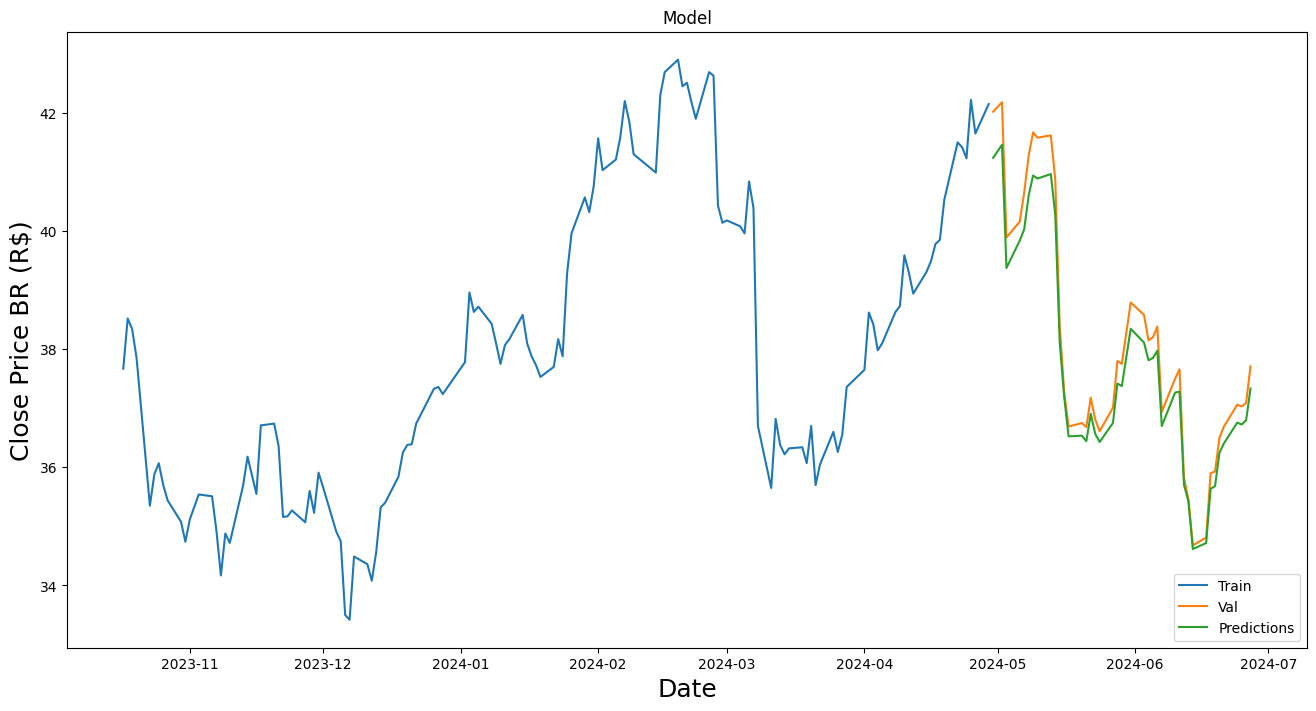

In [13]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price BR (R$)', fontsize=18)
plt.plot(train['Close'][-132:])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


(41, 2)
(500, 1)


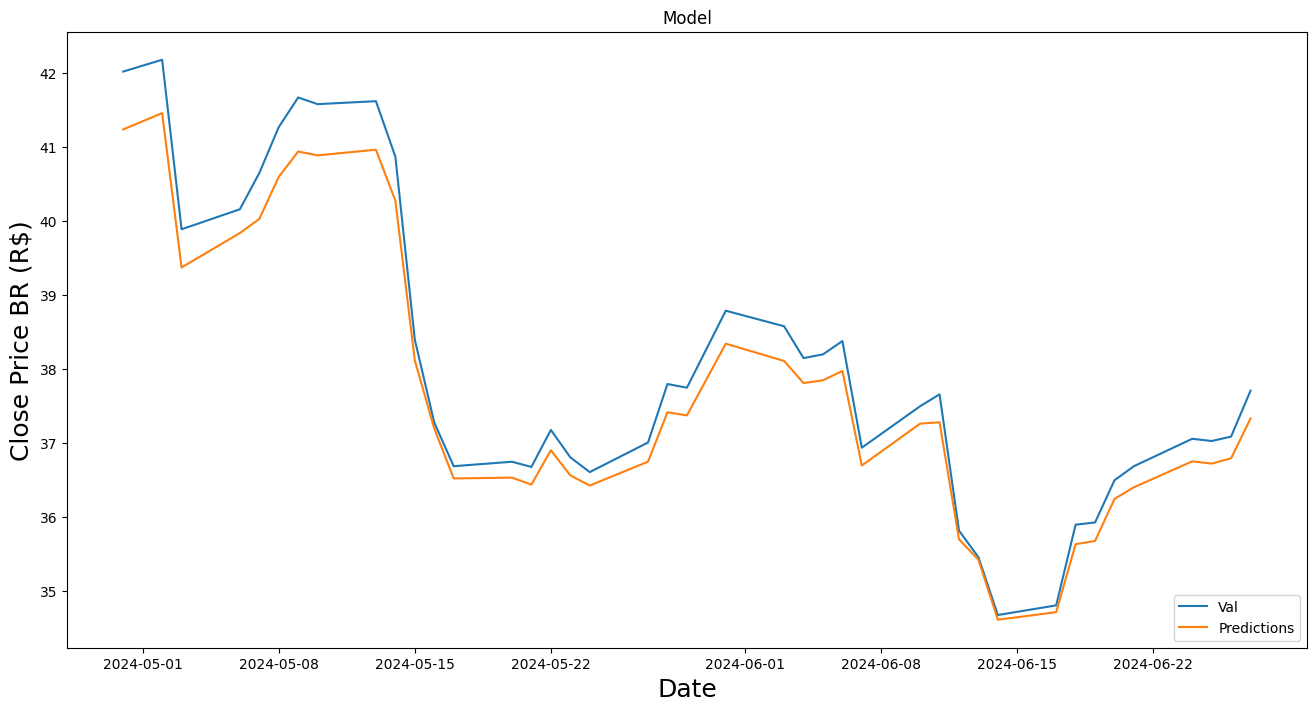

In [17]:
print(valid.shape)
print(train.shape)
# Plot the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price BR (R$)', fontsize=18)

a = valid[['Predictions']]*(1+np.mean(((np.array(valid[['Close']]) / ((np.array(valid[['Predictions']]))))-1)))

plt.plot(valid[['Close']])
# plt.plot(a)
plt.plot(valid[['Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()

1.0001607515514663
(41, 1)


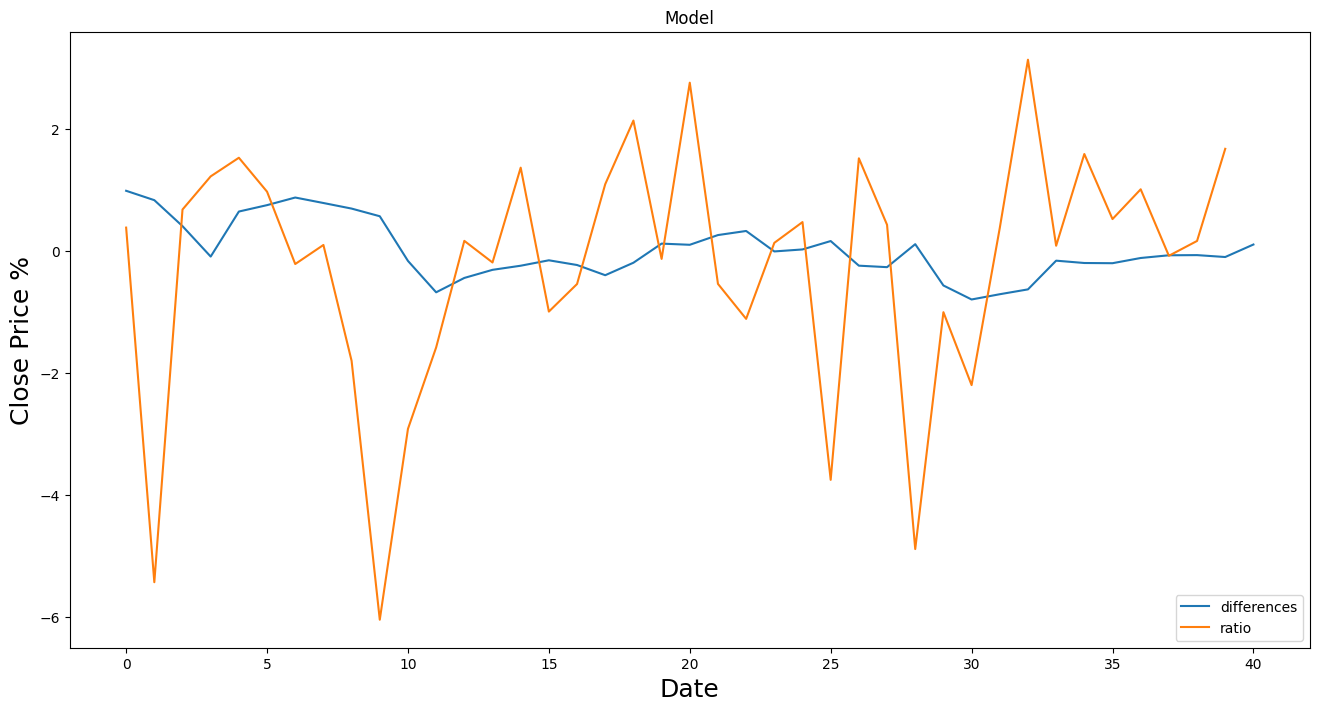

In [18]:
# Calculate the difference
def calculate_a_ratio(val, predictions):
  return ((np.array(val) / ((np.array(predictions))*1.009010411663203))-1)*100

def calculate_change_ratio(val):
  print(val.shape)
  a = np.array(val[1:])
  b = np.array(val[:-1])
  ratios = ((a / b)-1)*100
  # print(ratios)
  return ratios

differences = calculate_a_ratio(valid[['Close']], valid[['Predictions']])
print(1+np.mean(differences)/100)
ratio = calculate_change_ratio(valid[['Close']])

# print(differences)
# Plot the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price %', fontsize=18)
plt.plot(differences)
plt.plot(ratio)
plt.legend(['differences','ratio'], loc='lower right')
plt.show()

1/1 [==============================] - 0s 24ms/step
Next month's predicted closing prices:
[[37.843678]
 [37.96531 ]
 [38.05352 ]
 [38.12671 ]
 [38.187523]
 [38.239655]
 [38.285664]
 [38.327454]
 [38.366295]
 [38.402985]
 [38.437984]
 [38.471577]
 [38.503815]
 [38.53468 ]
 [38.564087]
 [38.592003]
 [38.61838 ]
 [38.643246]
 [38.666626]
 [38.688538]]


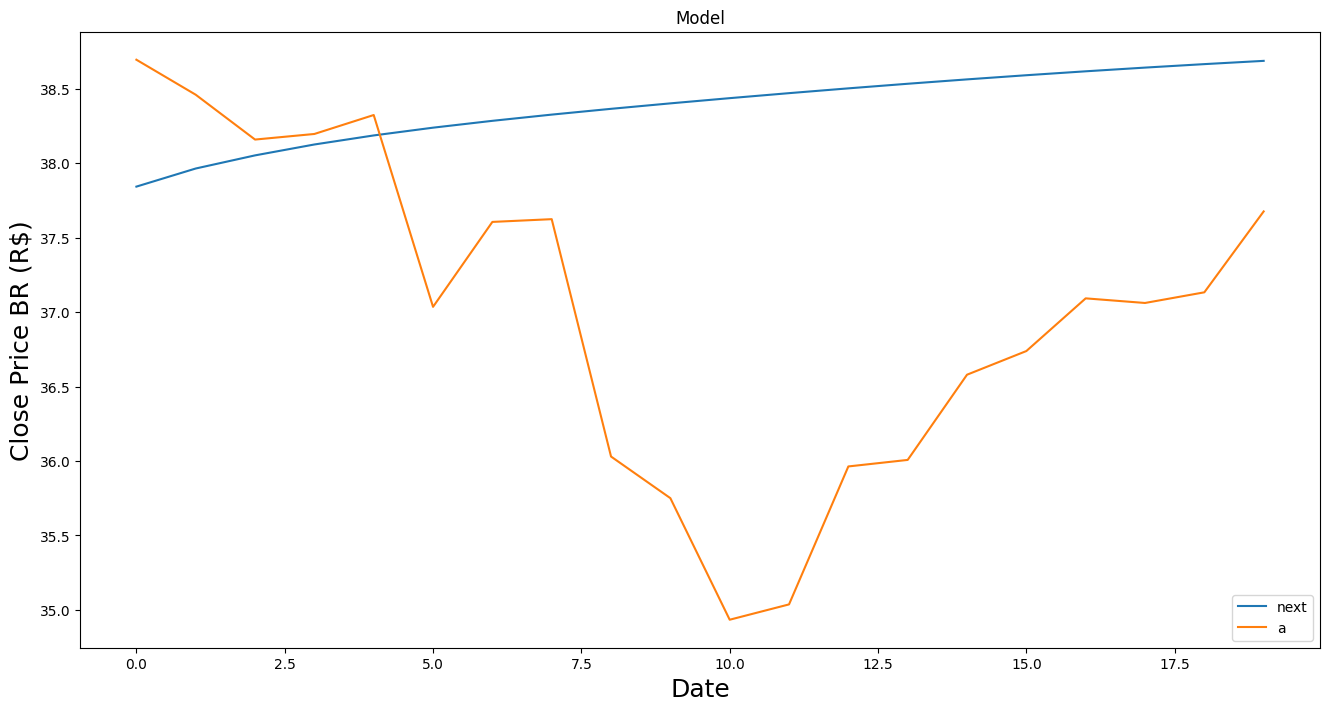

In [20]:

def predict_next_month(model_path, data, scaler, time_step=21):
    """
    Predict the next month's closing prices using a trained LSTM model.

    Parameters:
    - model_path: Path to the trained LSTM model.
    - data: Historical data used for training the model.
    - scaler: Scaler used to normalize the data.
    - time_step: Number of previous time steps used to make a prediction.

    Returns:
    - predictions: Predicted closing prices for the next month.
    """
    # Load the trained model
    model = load_model(model_path)

    # Get the last `time_step` days from the data
    last_days = data[- time_step - 21:-21]
    scaled_last_days = scaler.transform(last_days)

    # Prepare the input data for prediction
    X_pred = []
    X_pred.append(scaled_last_days)
    X_pred = np.array(X_pred)
    X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1], 1))

    # Predict the next month (20 trading days)
    predictions = []
    for i in range(20):
        pred = model.predict(X_pred)
        predictions.append(pred[0, 0])

        # Update the input data with the latest prediction
        scaled_last_days = np.append(scaled_last_days[1:], pred)
        X_pred = np.reshape(scaled_last_days, (1, time_step, 1))

    # Inverse transform the predictions to get the actual values
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    return predictions

# Assuming you have the model saved at 'best_model.h5', data, and scaler
next_month_predictions = predict_next_month('/content/drive/MyDrive/Colab Notebooks/SML/article/model_64', data.values, scaler)

print("Next month's predicted closing prices:")
print(next_month_predictions)

# Plot the data
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price BR (R$)', fontsize=18)
b = np.array(next_month_predictions)
plt.plot(b)
plt.plot(np.array(a[21:]))
plt.legend(['next', 'a'], loc='lower right')
plt.show()